# Support Vector Machine Models for Depression and Anxiety #

In this notebook, we train Support Vector Machine models to predict depression and anxiety using only the training data. We use the same set of predictors as in the Ridge notebook and again remove medication use and substance use. We apply preprocessing to scale numeric values and encode categorical values, and we test several SVM settings using cross validation, including different kernels and penalty strengths. We evaluate performance with measures that show both average prediction errors and how well the model explains variation in the outcome.


In [5]:
#load the dataset
import pandas as pd
df = pd.read_csv("../Data/train.csv")


In [6]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

exclude_cols = ["Medication_Use", "Substance_Use"]
targets = ["Depression_Score", "Anxiety_Score"]

X = df.drop(columns=targets + exclude_cols)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [3]:
def target_svm(df, target_name):
    y = df[target_name]

    svm = SVR()

    pipeline = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", svm),
    ])

    param_grid = {
        "model__C": [0.1, 1, 10],
        "model__gamma": ["scale", "auto"],
        "model__kernel": ["rbf", "linear"],
    }

    scoring = {
        "neg_mse": "neg_mean_squared_error",
        "r2": "r2"
    }

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit="neg_mse",
        cv=5,
        n_jobs=-1
    )


    grid.fit(X, y)

    best_neg_mse = grid.cv_results_['mean_test_neg_mse'][grid.best_index_]
    best_r2 = grid.cv_results_['mean_test_r2'][grid.best_index_]


    print(f" SVM Results for target: {target_name}")
    print("Best params:", grid.best_params_)
    print("Best CV RMSE:", np.sqrt(-best_neg_mse))
    print("Best CV R squared:", best_r2)
    print()

    return grid


   

In [4]:
svm_depression = target_svm(df, "Depression_Score")
svm_anxiety = target_svm(df, "Anxiety_Score")

 SVM Results for target: Depression_Score
Best params: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best CV RMSE: 5.71340562710138
Best CV R squared: -0.008479936920599496

 SVM Results for target: Anxiety_Score
Best params: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best CV RMSE: 5.9560669985118375
Best CV R squared: -0.013873389124976576



## Visualization of SVM ##

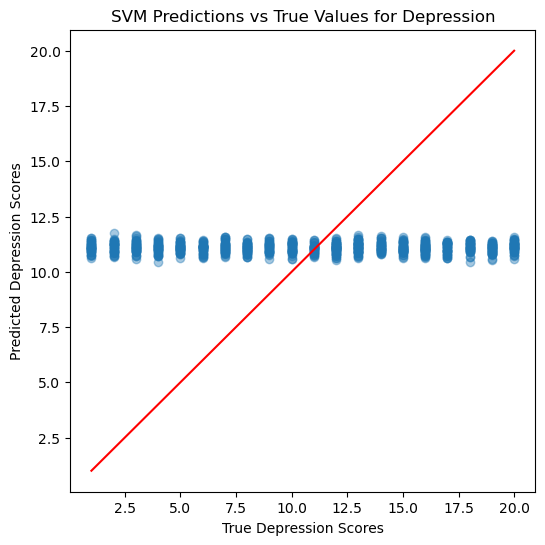

In [8]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

dep_X = df.drop(columns=targets + exclude_cols)
dep_y = df["Depression_Score"]

dep_preds = cross_val_predict(
    svm_depression.best_estimator_,
    dep_X,
    dep_y,
    cv=5,
)

plt.figure(figsize=(6, 6))
plt.scatter(dep_y, dep_preds, alpha=0.4)
plt.plot([dep_y.min(), dep_y.max()], 
         [dep_y.min(), dep_y.max()], 
         color='red')

plt.xlabel("True Depression Scores")
plt.ylabel("Predicted Depression Scores")
plt.title("SVM Predictions vs True Values for Depression")
plt.show()

The points form a nearly horizontal band instead of following the diagonal reference line, which shows that the SVM produces very similar predictions for most individuals regardless of the true depression score. This indicates that the model is unable to capture strong relationships between the predictors and depression scores in this dataset.

---

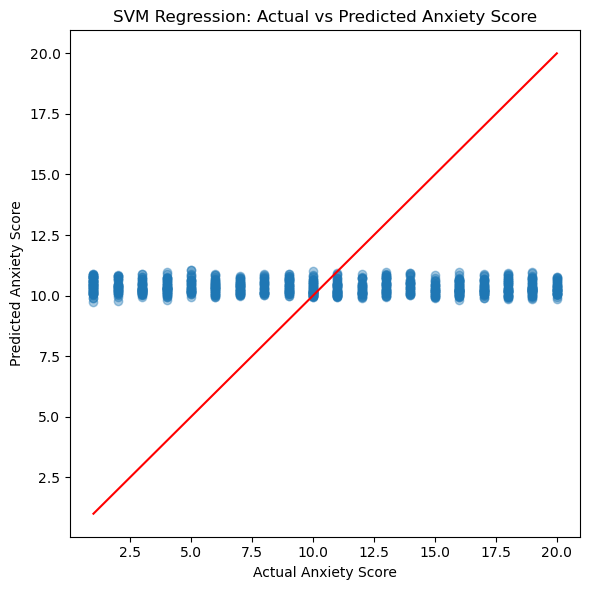

In [10]:
anx_X = df.drop(columns=targets + exclude_cols)
anx_y = df["Anxiety_Score"]

# Cross-validated predictions using best SVM model for Anxiety
y_pred_anx_svm = cross_val_predict(
    estimator=svm_anxiety.best_estimator_,
    X=anx_X,
    y=anx_y,
    cv=5
)

plt.figure(figsize=(6, 6))
plt.scatter(anx_y, y_pred_anx_svm, alpha=0.4)
plt.plot(
    [anx_y.min(), anx_y.max()],
    [anx_y.min(), anx_y.max()],
    color="red"
)
plt.xlabel("Actual Anxiety Score")
plt.ylabel("Predicted Anxiety Score")
plt.title("SVM Regression: Actual vs Predicted Anxiety Score")
plt.tight_layout()

## Results Summary ##
The Support Vector Machine models produced relatively large prediction errors for both depression and anxiety, with root mean squared errors close to six points. The models also showed slightly negative values for the R squared measure, which indicates that they did not explain more variation than simply predicting the average score. These results suggest that the SVM, at least with the features and parameter settings tested here, does not capture a strong relationship between the predictors and the mental health outcomes.